In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

In [2]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import cross_val_score,KFold
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.compose import TransformedTargetRegressor,ColumnTransformer



In [3]:

# Uncomment this line if using this notebook locally
# insurance = pd.read_csv('./data/insurance/insurance.csv') 

insurance = pd.read_csv('/mnt/d/portfolio/Insurance_premium_Prediction/Data/insurance.csv')

# Preview our data
insurance.head()

,Unnamed: 0,age,sex,bmi,children,smoker,region,charges
0,0,19,female,27.900,0,yes,southwest,16884.92400
1,1,18,male,33.770,1,no,southeast,1725.55230
2,2,28,male,33.000,3,no,southeast,4449.46200
3,3,33,male,22.705,0,no,northwest,21984.47061
4,4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1338 non-null   int64  
 1   age         1338 non-null   int64  
 2   sex         1338 non-null   object 
 3   bmi         1338 non-null   float64
 4   children    1338 non-null   int64  
 5   smoker      1338 non-null   object 
 6   region      1338 non-null   object 
 7   charges     1338 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 83.8+ KB


In [5]:
insurance.describe()

,Unnamed: 0,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,668.500000,39.207025,30.663397,1.094918,13270.422265
std,386.391641,14.049960,6.098187,1.205493,12110.011237
min,0.000000,18.000000,15.960000,0.000000,1121.873900
25%,334.250000,27.000000,26.296250,0.000000,4740.287150
50%,668.500000,39.000000,30.400000,1.000000,9382.033000
75%,1002.750000,51.000000,34.693750,2.000000,16639.912515
max,1337.000000,64.000000,53.130000,5.000000,63770.428010


In [6]:
insurance.nunique()

Unnamed: 0    1338
age             47
sex              2
bmi            548
children         6
smoker           2
region           4
charges       1337
dtype: int64

### Univariate analysis

In [7]:
cat_cols    = insurance.select_dtypes('object').columns.to_list()
ordinal_cols = [col for col in insurance.columns.to_list() if insurance[col].nunique()<10 and col not in cat_cols]
num_cols     = [col for col in insurance.columns.to_list() if col not in cat_cols+ordinal_cols]

In [8]:
cat_cols

['sex', 'smoker', 'region']

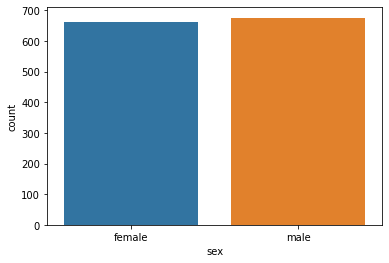

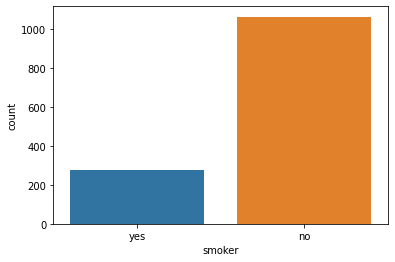

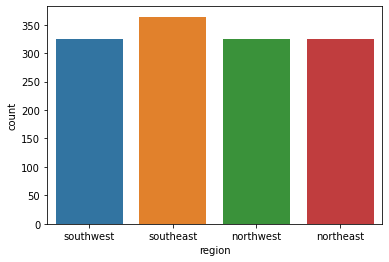

In [9]:
for col in cat_cols:
    sns.countplot(data=insurance,x=col)
    plt.show()

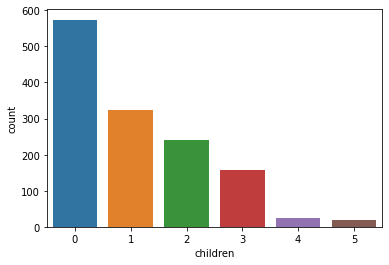

In [10]:
for col in ordinal_cols:
    sns.countplot(data=insurance,x=col)
    plt.show()

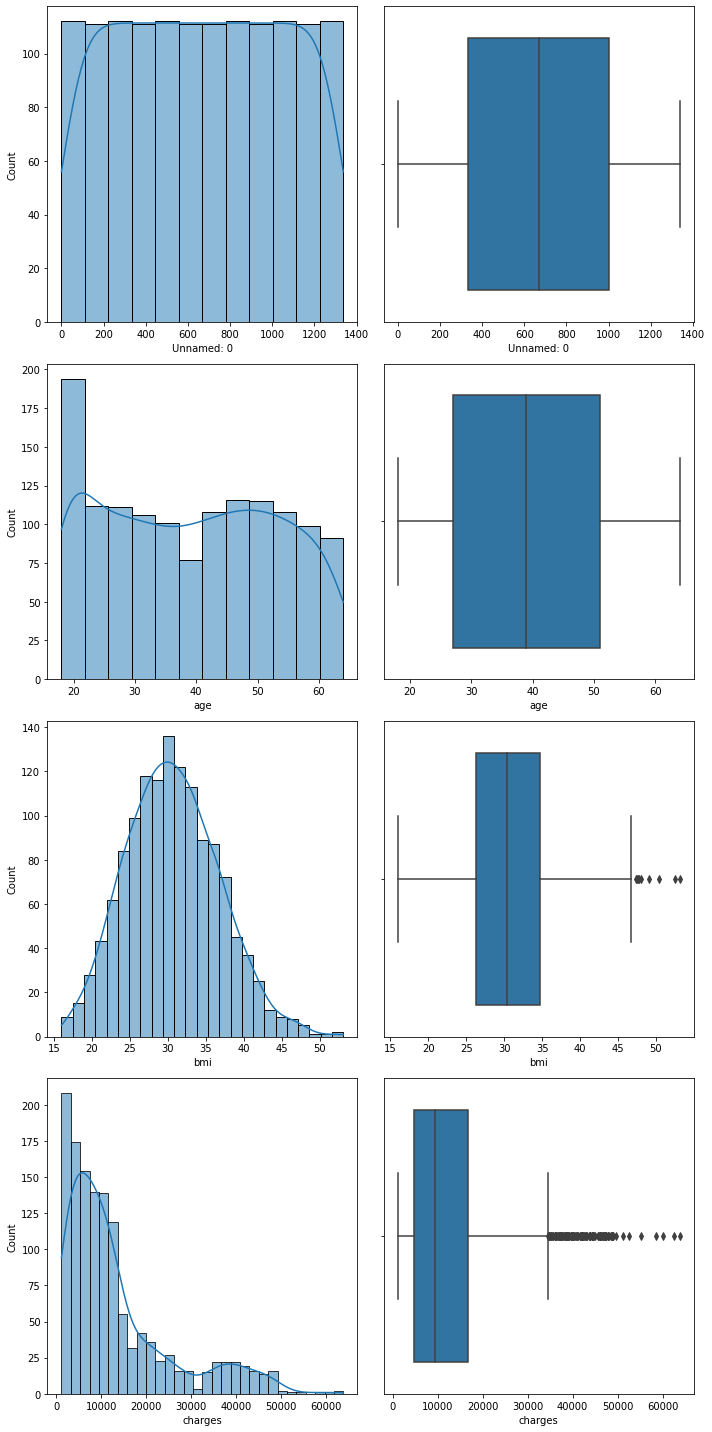

In [11]:
fig, axes = plt.subplots(nrows=len(num_cols), ncols=2, figsize=(10, 5*len(num_cols)))
for i,col in enumerate(num_cols):
    
    sns.histplot(data=insurance,x=col,kde=True,ax=axes[i][0])
    sns.boxplot(data=insurance,x=col,ax=axes[i][1])
plt.tight_layout()
    
plt.show()

In [66]:
insurance[insurance['charges']>45000].shape

(38, 8)

In [12]:
mean_ins = insurance['charges'].mean()
std_ins = insurance['charges'].std()

z_score = ((insurance['charges']-mean_ins)/std_ins)

outliers = insurance['charges'][np.abs(z_score)>3]
outliers

34      51194.55914
543     63770.42801
577     58571.07448
819     55135.40209
1146    52590.82939
1230    60021.39897
1300    62592.87309
Name: charges, dtype: float64

## Target variable charges distribution is right skewed and has outliers. Apply log transformation to convert to normal distribution

### Bivariate Analysis

In [13]:
insurance

,Unnamed: 0,age,sex,bmi,children,smoker,region,charges
0,0,19,female,27.900,0,yes,southwest,16884.92400
1,1,18,male,33.770,1,no,southeast,1725.55230
2,2,28,male,33.000,3,no,southeast,4449.46200
3,3,33,male,22.705,0,no,northwest,21984.47061
4,4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...,...
1333,1333,50,male,30.970,3,no,northwest,10600.54830
1334,1334,18,female,31.920,0,no,northeast,2205.98080
1335,1335,18,female,36.850,0,no,southeast,1629.83350
1336,1336,21,female,25.800,0,no,southwest,2007.94500


<AxesSubplot:xlabel='age', ylabel='charges'>

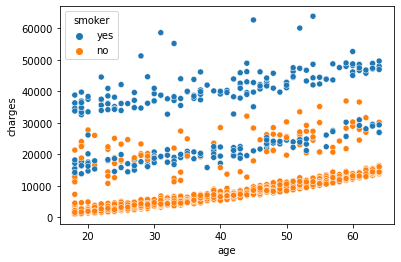

In [14]:
sns.scatterplot(data=insurance,x='age',y='charges',hue='smoker')

<AxesSubplot:xlabel='bmi', ylabel='charges'>

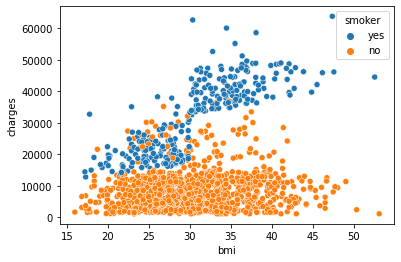

In [15]:
sns.scatterplot(data=insurance,x='bmi',y='charges',hue='smoker')

We can see that non smoker has less charges while smoker has high charge as they can be subjected to health risks. And also as age increases the charge also increase


<AxesSubplot:xlabel='region'>

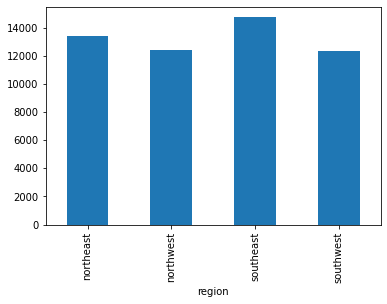

In [16]:
insurance.groupby('region')['charges'].mean().plot(kind='bar')

<AxesSubplot:xlabel='smoker'>

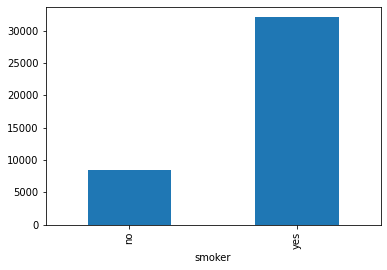

In [17]:
insurance.groupby('smoker')['charges'].mean().plot(kind='bar')

<AxesSubplot:xlabel='children'>

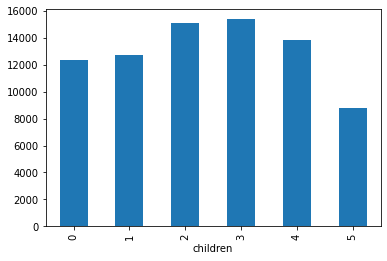

In [18]:
insurance.groupby('children')['charges'].mean().plot(kind='bar')

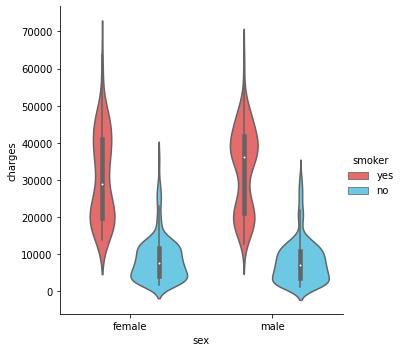

In [19]:
pal = ["#FA5858", "#58D3F7"]
sns.catplot(x="sex", y="charges", hue="smoker",
            kind="violin", data=insurance, palette = pal)

Text(0.5, 1.0, 'Smokers')

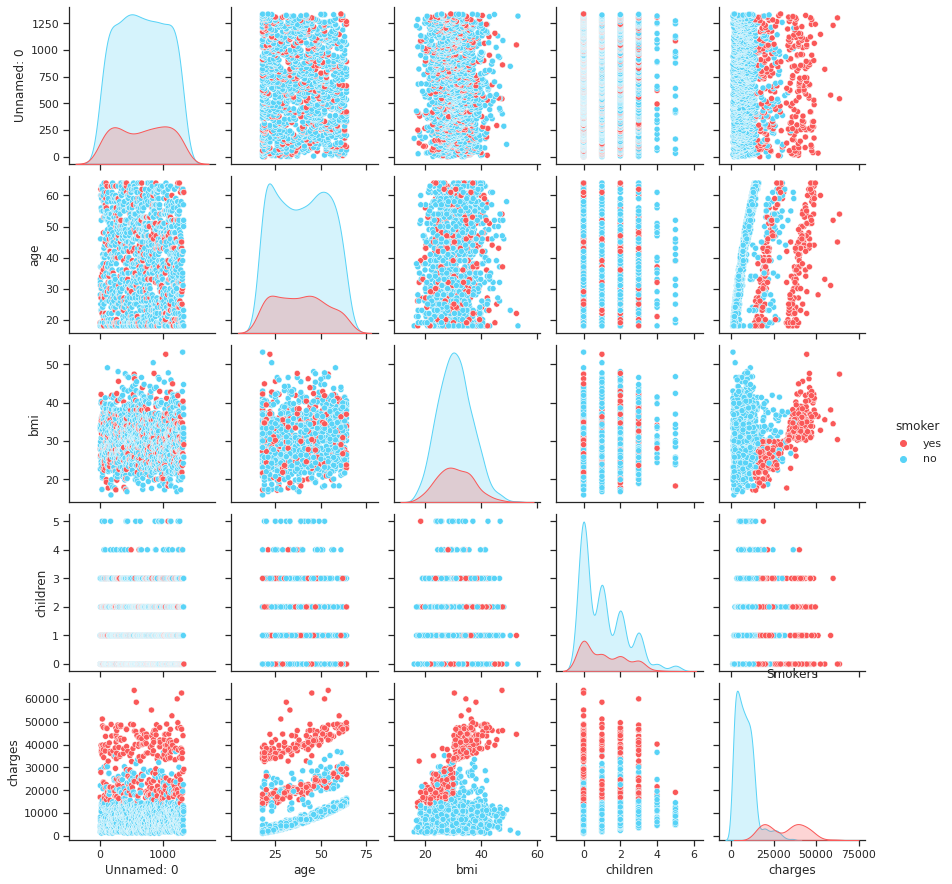

In [20]:

sns.set(style="ticks")
pal = ["#FA5858", "#58D3F7"]

sns.pairplot(insurance, hue="smoker", palette=pal)
plt.title("Smokers")

<AxesSubplot:>

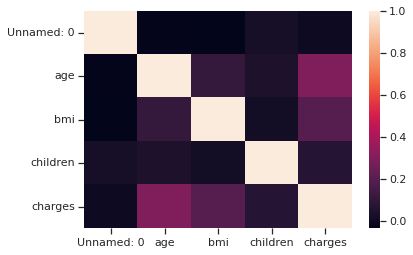

In [21]:
sns.heatmap(insurance.corr())

Data Preparation

In [22]:
def remove_outliers_iqr(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out outliers
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    print(len(df_filtered))
    
    return df_filtered

In [67]:
data_encoded = pd.get_dummies(insurance, columns=['region'], drop_first=True)
data_encoded = remove_outliers_iqr(data_encoded,'bmi')
data_encoded = data_encoded[data_encoded['charges']<45000]

1329


In [68]:
X = data_encoded.drop(columns=['charges','Unnamed: 0'],axis=1)
Y = data_encoded['charges']

In [69]:
X

,age,sex,bmi,children,smoker,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,0,0,1
1,18,male,33.770,1,no,0,1,0
2,28,male,33.000,3,no,0,1,0
3,33,male,22.705,0,no,1,0,0
4,32,male,28.880,0,no,1,0,0
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,1,0,0
1334,18,female,31.920,0,no,0,0,0
1335,18,female,36.850,0,no,0,1,0
1336,21,female,25.800,0,no,0,0,1


In [70]:
X['sex']    = X['sex'].apply(lambda x : 0 if x=='female' else 1)
X['smoker'] = X['smoker'].apply(lambda x : 0 if x=='no' else 1)

In [71]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2)

<AxesSubplot:xlabel='charges', ylabel='Count'>

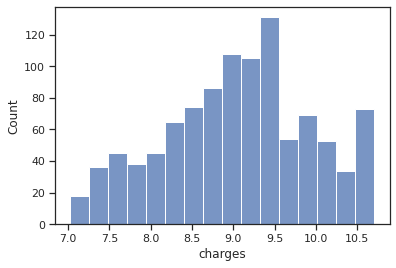

In [72]:
sns.histplot(np.log1p(y_train))

## Modelling

In [73]:
def model_measure(model):
    model.fit(x_train,np.log1p(y_train))

    cv = KFold(n_splits=5,shuffle=True,random_state=42)
    scores = cross_val_score(model,x_train,np.log1p(y_train),cv=cv,scoring='neg_mean_squared_error')
    print(f'scores from cross_validation:{scores}')

    y_pred = np.expm1(model.predict(x_test))
    rmse = mean_squared_error(y_test,y_pred,squared=False)
    mae = mean_absolute_error(y_test,y_pred)
    r2 = r2_score(y_pred=y_pred,y_true=y_test)

    print(f'RMSE value from model predictions:{rmse}')
    print(f'MAE value from model predictions:{mae}')
    print(f'R2 score from model predictions:{r2}')
    return rmse,mae,r2,y_pred

In [75]:
linear = LinearRegression()
linear_rmse,linear_mae,linear_r2,linear_pred = model_measure(linear)


scores from cross_validation:[-0.22849155 -0.13747465 -0.220937   -0.24877751 -0.22005571]
RMSE value from model predictions:7445.594659143736
MAE value from model predictions:3539.9570535871994
R2 score from model predictions:0.49374848343031197


In [77]:
first_results = {'linear':[linear_rmse,linear_mae,linear_r2]}

/home/mtr_055/miniconda3/envs/learning/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='charges'>

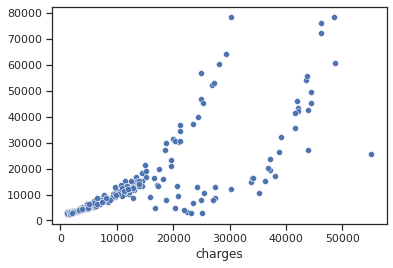

In [32]:
sns.scatterplot(y_test,linear_pred)

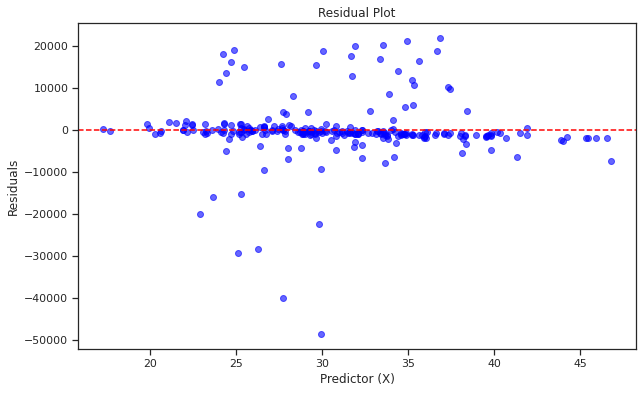

In [78]:
residuals = y_test - linear_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(x_test['bmi'], residuals, color='blue', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predictor (X)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [79]:
ridge = Ridge()
ridge_rmse,ridge_mae,ridge_r2,ridge_pred = model_measure(ridge)
first_results['ridge'] = [ridge_rmse,ridge_mae,ridge_r2]


scores from cross_validation:[-0.22909386 -0.13790434 -0.22047193 -0.24852457 -0.21988294]
RMSE value from model predictions:7394.036628694532
MAE value from model predictions:3530.134305376461
R2 score from model predictions:0.5007354230080532


In [80]:
dtree = DecisionTreeRegressor()
dtree_rmse,dtree_mae,dtree_r2,dtree_pred = model_measure(dtree)
first_results['dtree'] = [dtree_rmse,dtree_mae,dtree_r2]

scores from cross_validation:[-0.44939079 -0.21627029 -0.39439059 -0.29897248 -0.37179304]
RMSE value from model predictions:5843.71893191303
MAE value from model predictions:2551.3220647837848
R2 score from model predictions:0.6881496778130538


In [81]:
rtree = RandomForestRegressor()
rtree_rmse,rtree_mae,rtree_r2,rtree_pred = model_measure(rtree)
first_results['rtree'] = [rtree_rmse,rtree_mae,rtree_r2]

scores from cross_validation:[-0.20308789 -0.08809348 -0.23579259 -0.1890661  -0.21709849]
RMSE value from model predictions:3738.137718463708
MAE value from model predictions:1809.5914174899563
R2 score from model predictions:0.8723919261856319


In [82]:
ada = AdaBoostRegressor()
ada_rmse,ada_mae,ada_r2,ada_pred = model_measure(ada)
first_results['ada'] = [ada_rmse,ada_mae,ada_r2]

scores from cross_validation:[-0.21466828 -0.21685966 -0.25531116 -0.28847942 -0.2796921 ]
RMSE value from model predictions:4174.475997016439
MAE value from model predictions:2941.217571328441
R2 score from model predictions:0.840862879695889


In [83]:
cat = CatBoostRegressor()
cat_rmse,cat_mae,cat_r2,cat_pred = model_measure(cat)
first_results['cat'] = [cat_rmse,cat_mae,cat_r2]

Learning rate set to 0.04116
0:	learn: 0.8589704	total: 37.5ms	remaining: 37.5s
1:	learn: 0.8368557	total: 41.6ms	remaining: 20.8s
2:	learn: 0.8143168	total: 43.2ms	remaining: 14.4s
3:	learn: 0.7940133	total: 44.9ms	remaining: 11.2s
4:	learn: 0.7735593	total: 47ms	remaining: 9.36s
5:	learn: 0.7546329	total: 48.6ms	remaining: 8.05s
6:	learn: 0.7351943	total: 50.3ms	remaining: 7.14s
7:	learn: 0.7184583	total: 50.8ms	remaining: 6.3s
8:	learn: 0.7016561	total: 52ms	remaining: 5.73s
9:	learn: 0.6848456	total: 53.1ms	remaining: 5.26s
10:	learn: 0.6684499	total: 54.4ms	remaining: 4.89s
11:	learn: 0.6540030	total: 55.4ms	remaining: 4.56s
12:	learn: 0.6403544	total: 56.6ms	remaining: 4.3s
13:	learn: 0.6278344	total: 57.8ms	remaining: 4.07s
14:	learn: 0.6149440	total: 58.9ms	remaining: 3.87s
15:	learn: 0.6039731	total: 59.5ms	remaining: 3.66s
16:	learn: 0.5917416	total: 61ms	remaining: 3.53s
17:	learn: 0.5801445	total: 63.2ms	remaining: 3.45s
18:	learn: 0.5697965	total: 64.3ms	remaining: 3.32s
1

In [85]:
lgb = lgb.LGBMRegressor()
lgb_rmse,lgb_mae,lgb_r2,lgb_pred = model_measure(lgb)
first_results['lgb'] = [lgb_rmse,lgb_mae,lgb_r2]

AttributeError: 'LGBMRegressor' object has no attribute 'LGBMRegressor'

In [40]:
svr = SVR(kernel='rbf', C=1.0, epsilon=0.2)
svr_rmse,svr_mae,svr_r2,svr_pred = model_measure(svr)
first_results['svr'] = [svr_rmse,svr_mae,svr_r2]

scores from cross_validation:[-0.61314689 -0.47915971 -0.61969825 -0.70843264 -0.57799846]
RMSE value from model predictions:11323.34870069391
MAE value from model predictions:6261.777861383503
R2 score from model predictions:0.08021629769605654


In [86]:
xgbr = XGBRegressor()

xgbr_rmse,xgbr_mae,xgbr_r2,xgbr_pred = model_measure(xgbr)
first_results['xgbr'] = [xgbr_rmse,xgbr_mae,xgbr_r2]

scores from cross_validation:[-0.24702255 -0.10411105 -0.22832959 -0.2364865  -0.25365391]
RMSE value from model predictions:5511.204206423962
MAE value from model predictions:2697.1274024422955
R2 score from model predictions:0.7226293112599196


In [87]:
gbr = GradientBoostingRegressor()
gbr_rmse,gbr_mae,gbr_r2,gbr_pred = model_measure(gbr)
first_results['gbr'] = [gbr_rmse,gbr_mae,gbr_r2]

scores from cross_validation:[-0.15208182 -0.07243609 -0.1967941  -0.194993   -0.19255389]
RMSE value from model predictions:3733.4811411692394
MAE value from model predictions:1861.7812488678712
R2 score from model predictions:0.8727096495000346


In [88]:
pd.DataFrame(first_results,index=['rmse','mse','r2'])

,linear,ridge,dtree,rtree,ada,cat,xgbr,gbr
rmse,7445.594659,7394.036629,5843.718932,3738.137718,4174.475997,4164.632684,5511.204206,3733.481141
mse,3539.957054,3530.134305,2551.322065,1809.591417,2941.217571,2147.314080,2697.127402,1861.781249
r2,0.493748,0.500735,0.688150,0.872392,0.840863,0.841612,0.722629,0.872710


In [41]:
import shap

ModuleNotFoundError: No module named 'shap'

In [ ]:

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=data.feature_names)

## Hyper parameter tuning

In [89]:
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    
    # Create the model
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        random_state=42
    )
    
    # Train the model
    model.fit(x_train,np.log1p(y_train))
    

    # Predict and evaluate
    y_pred = np.expm1(model.predict(x_test))
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    return rmse


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2024-06-05 18:24:47,182] A new study created in memory with name: no-name-4e5eb94c-5d2b-45af-a393-a826faf8349b
[I 2024-06-05 18:24:47,716] Trial 0 finished with value: 3678.501868738991 and parameters: {'n_estimators': 110, 'learning_rate': 0.06326275221979182, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.9504729640286351}. Best is trial 0 with value: 3678.501868738991.
[I 2024-06-05 18:24:48,734] Trial 1 finished with value: 4091.6650347961895 and parameters: {'n_estimators': 460, 'learning_rate': 0.08306368174911871, 'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 15, 'subsample': 0.6444336295760364}. Best is trial 0 with value: 3678.501868738991.
[I 2024-06-05 18:24:49,062] Trial 2 finished with value: 3623.8790820640647 and parameters: {'n_estimators': 94, 'learning_rate': 0.07383403517829491, 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 16, 'subsample': 0.9605444057420812}. Best is trial 2 with value: 3623.8790820640

Best hyperparameters:  {'n_estimators': 328, 'learning_rate': 0.016454505354432422, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 19, 'subsample': 0.6471170838895867}


In [90]:
post_metrics = {}

In [91]:
best_params = study.best_params
gradient_model = GradientBoostingRegressor(**best_params, random_state=42)

grdiant_rmse,gradient_mae,gradient_r2,gradient_pred = model_measure(gradient_model)
post_metrics['gradient'] = [grdiant_rmse,gradient_mae,gradient_r2]


scores from cross_validation:[-0.15369276 -0.07136549 -0.19020458 -0.19217023 -0.19588017]
RMSE value from model predictions:3544.515953659269
MAE value from model predictions:1707.1871154816106
R2 score from model predictions:0.8852688281780811


In [92]:
def objective(trial):
    # Suggest hyperparameters
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    }

    # Create the LightGBM model
    model = lgb.LGBMRegressor(**param, n_estimators=1000)

    # Train the model
    model.fit(x_train,np.log1p(y_train),
        eval_metric='rmse'
    )

    # Predict and evaluate
    y_pred = np.expm1(model.predict(x_test, num_iteration=model.best_iteration_))
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return rmse

# Create and optimize the study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print best trial results
print(f'Best trial RMSE: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}')


[I 2024-06-05 18:29:39,471] A new study created in memory with name: no-name-084173ca-d62f-40d4-86b7-70ec5acb2841
/home/mtr_055/miniconda3/envs/learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/home/mtr_055/miniconda3/envs/learning/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if sys.path[0] == '':
/home/mtr_055/miniconda3/envs/learning/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/

AttributeError: 'LGBMRegressor' object has no attribute 'LGBMRegressor'

In [ ]:
param = study.best_trial.params
lgb = lgb.LGBMRegressor(**param, n_estimators=1000)

lgb_rmse,lgb_r2,lgb_pred = model_measure(lgb)
post_metrics['gradient'] = [lgb_rmse,lgb_r2]
    

In [ ]:
def objective(trial):
    # Suggest hyperparameters
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 10.0),
        'random_strength': trial.suggest_loguniform('random_strength', 0.1, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'task_type': 'GPU' if trial.suggest_categorical('task_type', ['CPU', 'GPU']) == 'GPU' else 'CPU',
        'verbose': 0
    }

    # Create the CatBoost model
    model = CatBoostRegressor(**param)

    # Train the model
    model.fit(x_train,y_train)

    # Predict and evaluate
    y_pred = model.predict(x_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return rmse

# Create and optimize the study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print best trial results
print(f'Best trial RMSE: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}')


[I 2024-06-05 13:00:29,771] A new study created in memory with name: no-name-f94fd0dc-63ed-4876-958e-60f4ad2a1428
/home/mtr_055/miniconda3/envs/learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  """
/home/mtr_055/miniconda3/envs/learning/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  import sys
/home/mtr_055/miniconda3/envs/learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/

CatBoostError: catboost/cuda/cuda_lib/cuda_manager.cpp:201: Condition violated: `State == nullptr'

In [93]:
def objective(trial):
    params = {
        'n_estimators':trial.suggest_int('n_estimators',50,300),
        'max_depth':trial.suggest_int('max_depth',10,50),
        'min_samples_split':trial.suggest_int('min_samples_split',2,30),
        'min_samples_leaf':trial.suggest_int('min_samples_leaf',1,10),
        'bootstrap' :trial.suggest_categorical('bootstrap', [True, False]),
        'max_features' :trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])

    }

    model = RandomForestRegressor(**params)
    model.fit(x_train,np.log1p(y_train))
    
    y_pred = np.expm1(model.predict(x_test))
    model_rmse = mean_squared_error(y_test,y_pred,squared=False)
    return model_rmse

study = optuna.create_study(direction = 'minimize',sampler = optuna.samplers.TPESampler())
study.optimize(objective,n_trials=100)

best_params = study.best_params
print(best_params)


[I 2024-06-05 18:29:59,790] A new study created in memory with name: no-name-67d6f177-36da-47d0-b9a4-23bcabe5415e
[I 2024-06-05 18:30:00,275] Trial 0 finished with value: 4229.565638813996 and parameters: {'n_estimators': 103, 'max_depth': 22, 'min_samples_split': 25, 'min_samples_leaf': 8, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 0 with value: 4229.565638813996.
[I 2024-06-05 18:30:00,816] Trial 1 finished with value: 3561.7664668937714 and parameters: {'n_estimators': 99, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 9, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 1 with value: 3561.7664668937714.
[I 2024-06-05 18:30:01,150] Trial 2 finished with value: 3895.7134496758736 and parameters: {'n_estimators': 54, 'max_depth': 37, 'min_samples_split': 6, 'min_samples_leaf': 9, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 1 with value: 3561.7664668937714.
[I 2024-06-05 18:30:02,119] Trial 3 finished with value: 4552.400149795298 a

{'n_estimators': 100, 'max_depth': 48, 'min_samples_split': 3, 'min_samples_leaf': 9, 'bootstrap': True, 'max_features': 'auto'}


In [95]:
param = study.best_trial.params
rtree = RandomForestRegressor(**param)
rtree.fit(x_train,y_train)

rtree_rmse,rtree_mae,rtree_r2,rtree_pred = model_measure(rtree)
post_metrics['rtree'] = [rtree_rmse,rtree_mae,rtree_r2]

scores from cross_validation:[-0.15920655 -0.07479482 -0.18765897 -0.19630494 -0.19919873]
RMSE value from model predictions:3542.3572648052286
MAE value from model predictions:1670.3004667650914
R2 score from model predictions:0.8854085332814757


In [96]:
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    
    # Create the base estimator
    base_estimator = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split)
    
    # Create and train the AdaBoost model
    model = AdaBoostRegressor(
        base_estimator=base_estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )
    model.fit(x_train,np.log1p(y_train))
    y_pred = np.expm1(model.predict(x_test))
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred,squared=False)
    return mse

study = optuna.create_study(direction = 'minimize',sampler = optuna.samplers.TPESampler())
study.optimize(objective,n_trials=100)

best_params = study.best_params
print(best_params)


[I 2024-06-05 18:33:00,374] A new study created in memory with name: no-name-af8d32d3-30a9-499a-b3af-1c70692956d5
/home/mtr_055/miniconda3/envs/learning/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
[I 2024-06-05 18:33:01,544] Trial 0 finished with value: 3629.966844245182 and parameters: {'n_estimators': 154, 'learning_rate': 0.01910258229952812, 'max_depth': 6, 'min_samples_split': 9}. Best is trial 0 with value: 3629.966844245182.
/home/mtr_055/miniconda3/envs/learning/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_flo

{'n_estimators': 106, 'learning_rate': 0.05509419599037427, 'max_depth': 7, 'min_samples_split': 4}


In [98]:
    # Create and train the AdaBoost model
ada = AdaBoostRegressor(
        base_estimator = DecisionTreeRegressor(max_depth=7, min_samples_split=4),
        n_estimators=106,
        learning_rate=0.05509419599037427,
        random_state=42
    )

ada_rmse,ada_mae,ada_r2,gradient_pred = model_measure(ada)
post_metrics['ada'] = [ada_rmse,ada_mae,ada_r2]

scores from cross_validation:[-0.20906396 -0.09426377 -0.21066553 -0.18761973 -0.2090453 ]
RMSE value from model predictions:3568.629254478514
MAE value from model predictions:1930.0031785983908
R2 score from model predictions:0.8837024886890233


In [100]:
ada.fit(x_train,np.log1p(y_train))

cv = KFold(n_splits=5,shuffle=True,random_state=42)
scores = cross_val_score(ada,x_train,np.log1p(y_train),cv=cv,scoring='neg_mean_squared_error')
print(f'scores from cross_validation:{scores}')

y_pred = np.expm1(ada.predict(x_train))
rmse = mean_squared_error(y_train,y_pred,squared=False)
r2 = r2_score(y_pred=y_pred,y_true=y_train)

print(f'RMSE value from model predictions:{rmse}')
print(f'R2 score from model predictions:{r2}')

scores from cross_validation:[-0.16875156 -0.17927886 -0.13916057 -0.19433575 -0.12963232]
RMSE value from model predictions:4275.7525853950365
R2 score from model predictions:0.877354207870078


In [99]:
pd.DataFrame(post_metrics,index = ['rmse','mae','r2'])

,gradient,rtree,ada
rmse,3544.515954,3542.357265,3568.629254
mae,1707.187115,1670.300467,1930.003179
r2,0.885269,0.885409,0.883702


In [100]:
import pickle

# Assuming 'ada' is your trained AdaBoost model
with open('random_forest_reg.pkl', 'wb') as f:
    pickle.dump(rtree, f)

In [101]:
with open('random_forest_reg.pkl', 'rb') as f:
    loaded_ada = pickle.load(f)


In [102]:
testing = [[27,0,17.955,2,1,0,0,0]]
np.expm1(loaded_ada.predict(testing))

array([15957.81776654])

In [108]:
testing = [[27,0,17.955,2,1,0,0,0]]
np.expm1(loaded_ada.predict(testing))

array([17671.67073805])

In [105]:
testing = [[57,0,28.785,4,0,0,0,0]]
np.expm1(loaded_ada.predict(testing))

array([13257.94918994])

In [106]:
y_test[0]

16884.924